# TP9: Modelo de Lenguaje y Sistema de Recomendación

**Alumna**: Lucia Berard

**Fecha**: 01/06/2025

[Link a Google Colab](https://colab.research.google.com/drive/1ah4GT2vGlptvJM9qctPRs0NpqqozR07z?usp=sharing)




Se desea crear un sistema para recomendar películas. El archivo `movies.csv` posee una base de datos donde usuarios calificaron (del 1 al 5) diferentes películas (0 significa sin calificar).


In [43]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


---

## (a) Modelo de Lenguaje

Se desea diseñar un buscador de títulos de películas, de manera que si el usuario comete algún error u omisión cuando lo escribe, el buscador pueda entenderlo. Para ello, se estudiará la similitud entre los *embeddings*. A continuación se describen los pasos para diseñar el buscador; se recomienda que los mismos sean métodos dentro de la clase del buscador mencionado:

### a.1 **Descargar las representaciones pre-entrenadas GloVe de dimensión 300.** 📦  
  El modelo pre-entrenado puede descargarse en  
  http://nlp.stanford.edu/data/glove.6B.zip

### a.2 **Cargar el modelo de lenguaje.** 📥  
  Posible código (adaptar a sus necesidades):
  ```python
  language_model = {}
  with open("glove.6B.300d.txt", encoding="utf-8") as f:
      for line in f:
          parts = line.strip().split()
          word = parts[0]
          vec = np.array(parts[1:], dtype=float)
          language_model[word] = vec
  ```


In [9]:
def cargar_glove(path="glove.6B/glove.6B.300d.txt"):
    language_model = {}
    with open(path, encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vec = np.array(parts[1:], dtype=float)
            language_model[word] = vec
    return language_model

# Carga el modelo (esto puede tardar unos minutos)
glove = cargar_glove("glove.6B/glove.6B.300d.txt")
print(f"Modelo cargado. Palabras en el vocabulario: {len(glove)}")

# Mostrar una línea real del archivo glove.6B.300d.txt
with open("glove.6B/glove.6B.300d.txt", encoding="utf-8") as f:
    linea = next(f)
    print(linea)

Modelo cargado. Palabras en el vocabulario: 400000
the 0.04656 0.21318 -0.0074364 -0.45854 -0.035639 0.23643 -0.28836 0.21521 -0.13486 -1.6413 -0.26091 0.032434 0.056621 -0.043296 -0.021672 0.22476 -0.075129 -0.067018 -0.14247 0.038825 -0.18951 0.29977 0.39305 0.17887 -0.17343 -0.21178 0.23617 -0.063681 -0.42318 -0.11661 0.093754 0.17296 -0.33073 0.49112 -0.68995 -0.092462 0.24742 -0.17991 0.097908 0.083118 0.15299 -0.27276 -0.038934 0.54453 0.53737 0.29105 -0.0073514 0.04788 -0.4076 -0.026759 0.17919 0.010977 -0.10963 -0.26395 0.07399 0.26236 -0.1508 0.34623 0.25758 0.11971 -0.037135 -0.071593 0.43898 -0.040764 0.016425 -0.4464 0.17197 0.046246 0.058639 0.041499 0.53948 0.52495 0.11361 -0.048315 -0.36385 0.18704 0.092761 -0.11129 -0.42085 0.13992 -0.39338 -0.067945 0.12188 0.16707 0.075169 -0.015529 -0.19499 0.19638 0.053194 0.2517 -0.34845 -0.10638 -0.34692 -0.19024 -0.2004 0.12154 -0.29208 0.023353 -0.11618 -0.35768 0.062304 0.35884 0.02906 0.0073005 0.0049482 -0.15048 -0.12313 0.19

El archivo glove.6B.300d.txt contiene las representaciones vectoriales (embeddings) pre-entrenadas de palabras en inglés, generadas por el modelo GloVe (Global Vectors for Word Representation) utilizando un corpus de 6 mil millones de palabras (Wikipedia 2014 + Gigaword 5).
- Cada línea corresponde a una palabra del vocabulario.
- La primera palabra de cada línea es la palabra en sí.
- A continuación, hay 300 números separados por espacios, que representan el embedding (vector) de esa palabra en un espacio de 300 dimensiones.
- Estos vectores permiten comparar palabras de manera matemática, capturando similitudes semánticas (por ejemplo, "king" y "queen" tendrán vectores parecidos).


### a.3 Implementar un word2vec. Si la palabra está en el vocabulario debe devolver el vector del modelo de lenguaje, caso contrario debe devolver un vector de ceros.


In [13]:
def word2vec(word, language_model, dim=300):
    """
    Devuelve el vector de la palabra si está en el vocabulario,
    si no, devuelve un vector de ceros de dimensión 'dim'.
    """
    return language_model.get(word, np.zeros(dim))

# Ejemplo de uso con una palabra que está en el vocabulario
vector = word2vec("movie", glove)
print(vector)

# Ejemplo de uso con una palabra que no está en el vocabulario
vector = word2vec("afjsahjfsajfhsaj", glove)
print(vector)

[-0.138     -0.12203    0.0054643 -0.010215   0.13134    0.28616
 -0.36436   -0.035735  -0.17218   -0.38864    0.58637    0.13189
 -0.1513     0.35515   -0.34298   -0.54394   -0.40302   -0.17129
  0.19899    0.24317    0.21332    0.60335    0.22556    0.46382
  0.064101   0.36409    0.25328   -0.79771    0.26771    0.42462
 -0.62075    0.31208   -0.25316    0.13562   -1.1323     0.0099104
 -0.62471   -0.048047   0.23139    0.16102    0.24774   -0.26149
 -0.17341    0.34005    0.21511   -0.26714    0.45698   -0.13671
  0.11654   -0.12222    0.062068  -0.45585   -0.30115    0.11208
  0.31146   -0.048065   0.10067    0.1441     0.27139   -0.17809
 -0.41069    0.093994   0.499      0.023845   0.42438   -0.027703
  0.044485  -0.15928    0.45054    0.13142    0.19913    0.36483
  0.26074    0.55475    0.47258   -0.43104    0.23181   -0.177
  0.21771   -0.37325   -0.15304   -0.45237    0.68007   -0.15976
 -0.094521   0.6455     0.10443   -0.19616    0.027374  -0.24713
 -0.24108    0.24404   -



### a.4 Implementar una bolsa de palabras que transforme cualquier *string* en un vector. Los pasos a seguir son:
  - Convertir las mayúsculas en minúsculas.
  - Eliminar caracteres extraños.
  - Unificar espacios en blanco.
  - Convertir el *string* en una lista de palabras.
  - Convertir cada palabra en un *embedding* usando el `word2vec`.
  - Sumar las representaciones para formar un solo vector.

Para resolver este paso, se uso la libreria de Python `re` (Regular Expressions) para eliminar caracteres extraños

In [ ]:
def string2vec(text, language_model, dim=300):
    """
    Transforma un string en un vector embedding sumando los vectores de sus palabras.
    Pasos:
    1. Convierte a minúsculas.
    2. Elimina caracteres extraños.
    3. Unifica espacios en blanco.
    4. Divide en palabras.
    5. Convierte cada palabra en embedding usando word2vec.
    6. Suma los embeddings.
    """
    # 1. Minúsculas
    text = text.lower()
    # 2. Eliminar caracteres extraños (solo letras, números y espacios)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # 3. Unificar espacios en blanco
    text = re.sub(r'\s+', ' ', text).strip()
    # 4. Lista de palabras
    words = text.split()
    # 5. Embeddings y 6. Suma
    vecs = [word2vec(word, language_model, dim) for word in words]
    if vecs:
        return np.sum(vecs, axis=0)
    else:
        return np.zeros(dim)

# Verificacion:
vector = string2vec("The Lord of the Rings!", glove)
print(vector.shape)  # Debería ser (300,)

(300,)



### a.5 Se desea medir qué tan parecidos son dos *embeddings*. Para ello, implementar un código que calcule la similitud coseno.  
  La similitud coseno se define como:
  $$
  \mathrm{SC}(u, v) = \frac{u \cdot v}{\lVert u\rVert \;\lVert v\rVert}
  $$


In [ ]:
def similitud_coseno(u, v):
    """
    Calcula la similitud coseno entre dos vectores numpy.
    """
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    if norm_u == 0 or norm_v == 0:
        return 0.0
    return np.dot(u, v) / (norm_u * norm_v)

# Verificacion:
# Ejemplo 1: Dos strings idénticos
vec1 = string2vec("The Lord of the Rings", glove)
vec2 = string2vec("The Lord of the Rings", glove)
print("Similitud (idénticos):", similitud_coseno(vec1, vec2))  # Debería ser 1.0 o muy cercano

# Ejemplo 2: Muy parecidos (sin 'the')
vec3 = string2vec("Lord of the Rings", glove)
print("Similitud (muy parecidos):", similitud_coseno(vec1, vec3))  # Debería ser alto, pero < 1

# Ejemplo 3: Parcialmente relacionados
vec4 = string2vec("Harry Potter", glove)
print("Similitud (parcialmente relacionados):", similitud_coseno(vec1, vec4))  # Debería ser moderado o bajo

# Ejemplo 4: String vacío
vec6 = string2vec("", glove)
print("Similitud (con string vacío):", similitud_coseno(vec1, vec6))  # Debería ser 0

# Ejemplo 5: Palabra fuera del vocabulario
vec7 = string2vec("asdkfjhasdkjfh", glove)
print("Similitud (palabra inventada):", similitud_coseno(vec1, vec7))  # Debería ser 0

Similitud (idénticos): 1.0
Similitud (muy parecidos): 0.9846548635781329
Similitud (parcialmente relacionados): 0.27039834421986003
Similitud (distintos): 0.2911262796969033
Similitud (con string vacío): 0.0
Similitud (palabra inventada): 0.0



### a.6 Implementar un buscador que, dado un *string* (y su correspondiente *embedding*), devuelva la película con la representación más similar.


In [38]:
class BuscadorPeliculas:
    def __init__(self, titulos, language_model, dim=300):
        """
        titulos: lista de strings con los títulos de las películas
        language_model: diccionario de embeddings (GloVe)
        dim: dimensión de los embeddings
        """
        self.titulos = titulos
        self.language_model = language_model
        self.dim = dim
        # Precalcula los embeddings de todos los títulos
        self.embeddings = [string2vec(titulo, language_model, dim) for titulo in titulos]

    def buscar(self, consulta):
        """
        Dado un string de consulta, devuelve el título de película más similar.
        """
        consulta_vec = string2vec(consulta, self.language_model, self.dim)
        similitudes = [similitud_coseno(consulta_vec, emb) for emb in self.embeddings]
        idx_max = np.argmax(similitudes)
        if similitudes[idx_max] == 0: # Para evitar que devuelva un titulo por default
            return None, 0.0
        return self.titulos[idx_max], similitudes[idx_max]

# Verificacion:
# Cargar el archivo movies.csv
df_movies = pd.read_csv("movies.csv")
# Extraer la lista de títulos de la columna "Name"
titulos = df_movies["Name"].tolist()
buscador = BuscadorPeliculas(titulos, glove)
resultado, score = buscador.buscar("toy")
print(f"Película encontrada: {resultado} (similitud: {score:.3f})")

Película encontrada:  Toy Story (1995) (similitud: 0.704)



---

## (b) Sistema de Recomendación

Se desea diseñar el sistema de recomendación y utilizarlo para recomendarnos películas:

### b.1 Agregar un usuario a la base de datos con al menos 10 películas calificadas.  Utilice el buscador para no tener que escribir los títulos perfectos.


In [42]:
# Crear el buscador de películas
buscador = BuscadorPeliculas(titulos, glove)

usuario = {}
peliculas_a_calificar = [
    "toy",
    "star war",
    "french",
    "taxi driverr",
    "forrest gump",
    "godfather"
]

print("Califica las siguientes películas (de 1 a 5):")
for consulta in peliculas_a_calificar:
    titulo, score = buscador.buscar(consulta)
    print(f"Consulta: '{consulta}' → Título encontrado: '{titulo}' (similitud: {score:.3f})")
    calificacion = int(input(f"Tu calificación para '{titulo}': "))
    usuario[titulo] = calificacion

print("Tus calificaciones:")
for titulo, calificacion in usuario.items():
    print(f"{titulo}: {calificacion}")

# Agrego el usuario a movies.csv
# 1. Leer el archivo
df_movies = pd.read_csv("movies.csv")

# 2. Determinar el próximo nombre de usuario (user_N)
user_cols = [col for col in df_movies.columns if col.startswith("user_")]
if user_cols:
    last_user_num = max([int(col.split("_")[1]) for col in user_cols])
    nuevo_usuario_col = f"user_{last_user_num + 1}"
else:
    nuevo_usuario_col = "user_0"

# 3. Crear la columna con ceros
df_movies[nuevo_usuario_col] = 0

# 4. Asignar las calificaciones del diccionario 'usuario'
for titulo, calificacion in usuario.items():
    idx = df_movies[df_movies["Name"] == titulo].index
    if len(idx) > 0:
        df_movies.at[idx[0], nuevo_usuario_col] = calificacion

# 5. Guardar el DataFrame actualizado en el archivo (sobrescribe el CSV)
df_movies.to_csv("movies.csv", index=False)

print(f"Usuario agregado como columna '{nuevo_usuario_col}' en movies.csv")

Califica las siguientes películas (de 1 a 5):
Consulta: 'toy' → Título encontrado: ' Toy Story (1995)' (similitud: 0.704)
Consulta: 'star war' → Título encontrado: ' Star Wars (1977)' (similitud: 0.826)
Consulta: 'french' → Título encontrado: ' French Kiss (1995)' (similitud: 0.734)
Consulta: 'taxi driverr' → Título encontrado: ' Taxi Driver (1976)' (similitud: 0.812)
Consulta: 'forrest gump' → Título encontrado: ' Forrest Gump (1994)' (similitud: 0.922)
Consulta: 'godfather' → Título encontrado: ' Godfather, The (1972)' (similitud: 0.644)
Tus calificaciones:
 Toy Story (1995): 10
 Star Wars (1977): 1
 French Kiss (1995): 1
 Taxi Driver (1976): 1
 Forrest Gump (1994): 1
 Godfather, The (1972): 1
Usuario agregado como columna 'user_943' en movies.csv



### b.2 Utilizando **gradiente descendente**, entrenar un filtro colaborativo con un espacio latente de dimensión 10, $\lambda = 10$ y *learning rate* $10^{-3}$.  Graficar el riesgo regularizado empírico en función del número de iteraciones (al menos 2000).


¿Qué es un filtro colaborativo?
Es una técnica de recomendación que modela la interacción entre usuarios y películas (o ítems) en un espacio latente, es decir, representando tanto a usuarios como a películas con vectores de características ocultas de dimensión baja (acá, dimensión 10).

¿Qué significa "entrenar con gradiente descendente"?
El modelo busca encontrar los vectores latentes de usuarios y películas que mejor expliquen las calificaciones observadas. Para eso, se define una función de pérdida (error cuadrático + regularización) y se minimiza usando gradiente descendente: se ajustan los vectores latentes en cada iteración para reducir el error.

Parámetros específicos del enunciado:
- Espacio latente de dimensión 10: Cada usuario y cada película se representa con un vector de 10 números (características ocultas).
- λ = 10: Es la constante de regularización (penaliza que los vectores sean muy grandes, para evitar overfitting).
- learning rate = 10⁻³: Es el tamaño del paso que da el gradiente descendente en cada actualización.
- Al menos 2000 iteraciones: El entrenamiento debe durar al menos 2000 pasos de actualización.

Iteración 500, pérdida regularizada: 73663.67
Iteración 1000, pérdida regularizada: 73438.52
Iteración 1500, pérdida regularizada: 73401.70
Iteración 2000, pérdida regularizada: 73386.29


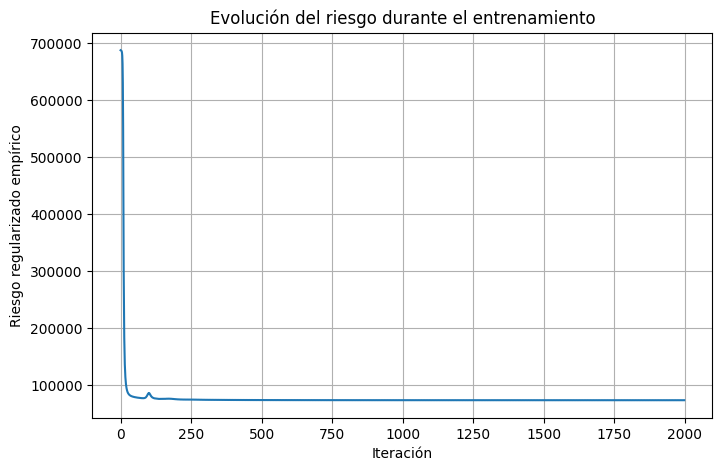

In [44]:
# 1. Cargar datos
df = pd.read_csv("movies.csv")
R = df.iloc[:, 1:].values  # ratings (sin la columna de nombres)
R = R.astype(float)
M, N = R.shape  # M: películas, N: usuarios

# 2. Parámetros
d = 10         # dimensión latente
lmbda = 10     # regularización
lr = 1e-3      # learning rate
n_iter = 2000  # número de iteraciones

# 3. Inicialización aleatoria
np.random.seed(42)
U = np.random.normal(0, 0.1, size=(M, d))  # películas
V = np.random.normal(0, 0.1, size=(N, d))  # usuarios

# 4. Guardar función de pérdida
losses = []

# 5. Máscara de ratings observados
mask = R > 0

# 6. Entrenamiento por gradiente descendente
for it in range(n_iter):
    # Predicción
    R_hat = U @ V.T

    # Error solo donde hay rating observado
    error = (R_hat - R) * mask

    # Función de pérdida regularizada
    loss = 0.5 * np.sum(error**2) + 0.5 * lmbda * (np.sum(U**2) + np.sum(V**2))
    losses.append(loss)

    # Gradientes
    dU = error @ V + lmbda * U
    dV = error.T @ U + lmbda * V

    # Actualización
    U -= lr * dU
    V -= lr * dV

    # Opcional: imprimir cada 500 iteraciones
    if (it+1) % 500 == 0:
        print(f"Iteración {it+1}, pérdida regularizada: {loss:.2f}")

# 7. Gráfico del riesgo regularizado empírico
plt.figure(figsize=(8,5))
plt.plot(losses)
plt.xlabel("Iteración")
plt.ylabel("Riesgo regularizado empírico")
plt.title("Evolución del riesgo durante el entrenamiento")
plt.grid()
plt.show()


### b.3 Crear un **rating** ponderando en partes iguales la salida del filtro colaborativo y la calificación media de las películas.


In [47]:
# R_hat es la matriz de predicciones del filtro colaborativo (U @ V.T)
# R es la matriz original de ratings

# 1. Calcular la media de cada película (ignorando ceros)
mean_movie_rating = np.sum(R, axis=1) / np.maximum(np.sum(R > 0, axis=1), 1)  # Evita división por cero

# 2. Expandir la media para que tenga la misma forma que R_hat
mean_matrix = np.tile(mean_movie_rating[:, np.newaxis], (1, R.shape[1]))

# 3. Calcular el rating combinado (ponderación 50% - 50%)
rating_final = 0.5 * R_hat + 0.5 * mean_matrix

# rating_final ahora contiene la puntuación ponderada para cada película-usuario
print("Ejemplo de rating final para la primera película y usuario:", rating_final[0,0])

Ejemplo de rating final para la primera película y usuario: 3.8407333964992985



### b.4 Recomendar las 5 películas **no vistas** con más alto **rating** al usuario creado anteriormente.


In [48]:
# 1. Índice del usuario (última columna)
user_idx = R.shape[1] - 1

# 2. Ratings originales del usuario
user_ratings = R[:, user_idx]

# 3. Ratings combinados del usuario
user_final_ratings = rating_final[:, user_idx]

# 4. Índices de películas no vistas
no_vistas_idx = np.where(user_ratings == 0)[0]

# 5. Ratings de las no vistas
ratings_no_vistas = user_final_ratings[no_vistas_idx]

# 6. Ordenar y seleccionar las 5 mejores
top5_idx = no_vistas_idx[np.argsort(ratings_no_vistas)[-5:][::-1]]

# 7. Mostrar títulos recomendados
titulos = df["Name"].values
print("Las 5 películas recomendadas para el usuario nuevo son:")
for i in top5_idx:
    print(f"- {titulos[i]} (rating: {user_final_ratings[i]:.2f})")

Las 5 películas recomendadas para el usuario nuevo son:
-  Schindler's List (1993) (rating: 3.27)
-  Princess Bride, The (1987) (rating: 3.26)
-  Empire Strikes Back, The (1980) (rating: 3.22)
-  Shawshank Redemption, The (1994) (rating: 3.20)
-  Raiders of the Lost Ark (1981) (rating: 3.19)
